# Mahalanobis outlier detection on KDD Cup '99 dataset

The outlier detector needs to detect computer network intrusions using TCP dump data for a local-area network (LAN) simulating a typical U.S. Air Force LAN. A connection is a sequence of TCP packets starting and ending at some well defined times, between which data flows to and from a source IP address to a target IP address under some well defined protocol. Each connection is labeled as either normal, or as an attack.

There are 4 types of attacks in the dataset:

- DOS: denial-of-service, e.g. syn flood;
- R2L: unauthorized access from a remote machine, e.g. guessing password;
- U2R: unauthorized access to local superuser (root) privileges;
- probing: surveillance and other probing, e.g., port scanning.

The dataset contains about 5 million connection records.

There are 3 types of features:

- basic features of individual connections, e.g. duration of connection
- content features within a connection, e.g. number of failed log in attempts
- traffic features within a 2 second window, e.g. number of connections to the same host as the current connection

In [1]:
import warnings
warnings.filterwarnings('ignore')  # suppress alibi warnings

from alibi.utils.mapping import ord_to_ohe
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
import sys
sys.path.append('..')

from odcd.od.mahalanobis import Mahalanobis
from odcd.datasets import fetch_kdd
from odcd.utils.data import create_outlier_batch
from odcd.utils.visualize import plot_outlier_scores

## Load dataset

We only keep a number of continuous (18 out of 41) features.

In [2]:
kddcup = fetch_kdd(percent10=True)  # only load 10% of the dataset
print(kddcup.data.shape, kddcup.target.shape)

(494021, 18) (494021,)


Assume that a model is trained on *normal* instances of the dataset (not outliers) and standardization is applied:

In [3]:
np.random.seed(0)
normal_batch = create_outlier_batch(kddcup.data, kddcup.target, n_samples=100000, perc_outlier=0)
data, target = normal_batch.data.astype('float'), normal_batch.target
print(data.shape, target.shape)
print('{}% outliers'.format(100 * target.mean()))

(100000, 18) (100000,)
0.0% outliers


In [4]:
mean, stdev = data.mean(axis=0), data.std(axis=0)

Generate batch of data with 10% outliers:

In [5]:
np.random.seed(1)
outlier_batch = create_outlier_batch(kddcup.data, kddcup.target, n_samples=100, perc_outlier=10)
data, target = outlier_batch.data.astype('float'), outlier_batch.target
print(data.shape, target.shape)
print('{}% outliers'.format(100 * target.mean()))

(100, 18) (100,)
10.0% outliers


Apply standardization:

In [6]:
data = (data - mean) / stdev

## Initialize and run outlier detector

Set parameters:

In [7]:
threshold = 6  # scores above threshold are classified as outliers
n_components = 2  # nb of components used in PCA
std_clip = 3  # clip values used to compute mean and cov above "std_clip" standard deviations
start_clip = 20  # start clipping values after "start_clip" instances

Initialize, predict outliers and get outlier scores:

In [8]:
mh = Mahalanobis(threshold, 
                 n_components=n_components, 
                 std_clip=std_clip, 
                 start_clip=start_clip)
preds = mh.predict(data)
scores = mh.score(data)

## Display results

Confusion matrix:

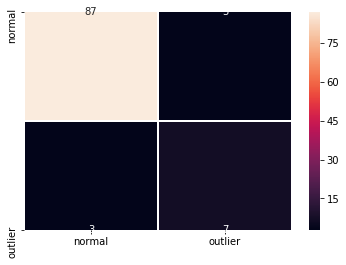

In [9]:
labels = outlier_batch.target_names
cm = confusion_matrix(target, preds)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
sns.heatmap(df_cm, annot=True, cbar=True, linewidths=.5)
plt.show()

Plot scores vs. the outlier threshold:

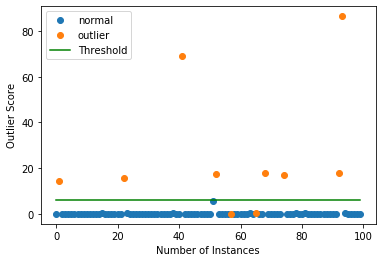

In [10]:
plot_outlier_scores(scores, target, labels, threshold)

## Include categorical variables

In [11]:
cat_cols = ['protocol_type', 'service', 'flag']
num_cols = ['srv_count', 'serror_rate', 'srv_serror_rate',
            'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 
            'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 
            'dst_host_srv_count', 'dst_host_same_srv_rate', 
            'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
            'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 
            'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 
            'dst_host_srv_rerror_rate']
cols = cat_cols + num_cols

In [12]:
np.random.seed(0)
kddcup = fetch_kdd(keep_cols=cols, percent10=True)
print(kddcup.data.shape, kddcup.target.shape)

(494021, 21) (494021,)


Create a dictionary with as keys the categorical columns and values the number of categories for each variable in the dataset. This dictionary will later be used in the `fit` step of the outlier detector.

In [13]:
cat_vars_ord = {}
n_categories = len(cat_cols)
for i in range(n_categories):
    cat_vars_ord[i] = len(np.unique(kddcup.data[:, i]))
print(cat_vars_ord)

{0: 3, 1: 66, 2: 11}


Fit an ordinal encoder on the categorical data:

In [14]:
enc = OrdinalEncoder()
enc.fit(kddcup.data[:, :n_categories])

OrdinalEncoder(categories='auto', dtype=<class 'numpy.float64'>)

Use the data to infer the numerical distances between the categorical variables. Just for illustrative purposes as it uses the outlier data already:

In [15]:
X_num = (kddcup.data[:, n_categories:] - mean) / stdev  # standardize numerical features
X_ord = enc.transform(kddcup.data[:, :n_categories])  # apply ordinal encoding to categorical features
X_fit = np.c_[X_ord, X_num].astype(np.float32, copy=False)  # combine numerical and categorical features
print(X_fit.shape)

(494021, 21)


Generate batch of data with 10% outliers:

In [16]:
np.random.seed(1)
outlier_batch = create_outlier_batch(kddcup.data, kddcup.target, n_samples=100, perc_outlier=10)
data, target = outlier_batch.data, outlier_batch.target
print(data.shape, target.shape)
print('{}% outliers'.format(100 * target.mean()))

(100, 21) (100,)
10.0% outliers


Preprocess the outlier batch:

In [17]:
X_num = (data[:, n_categories:] - mean) / stdev
X_ord = enc.transform(data[:, :n_categories])
X = np.c_[X_ord, X_num].astype(np.float32, copy=False)
print(X.shape)

(100, 21)


## Initialize and fit outlier detector

In [18]:
mh = Mahalanobis(threshold,
                 n_components=n_components, 
                 std_clip=std_clip, 
                 start_clip=start_clip,
                 cat_vars=cat_vars_ord,
                 ohe=False  # True if one-hot encoding (OHE) is used
                )

Set `fit` parameters:

In [19]:
d_type = 'abdm'  # pairwise distance type, 'abdm' infers context from other variables
disc_perc = [25, 50, 75]  # percentiles used to bin numerical values; used in 'abdm' calculations
standardize_cat_vars = True  # standardize numerical values of categorical variables

Apply `fit` method to find numerical values for categorical variables:

In [20]:
mh.fit(X_fit,
       d_type=d_type,
       disc_perc=disc_perc,
       standardize_cat_vars=standardize_cat_vars
      )

Another option would be to set `d_type` to `'mvdm'` and `y` to `kddcup.target` to infer the numerical values for categorical variables from the model labels (or alternatively the predictions).

## Run outlier detector and display results

In [21]:
preds = mh.predict(X)
scores = mh.score(X)

Confusion matrix:

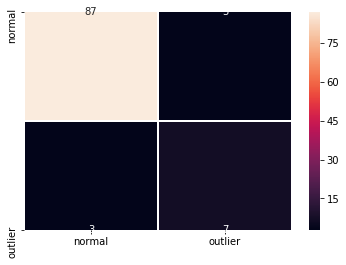

In [22]:
cm = confusion_matrix(target, preds)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
sns.heatmap(df_cm, annot=True, cbar=True, linewidths=.5)
plt.show()

Plot scores vs. the outlier threshold:

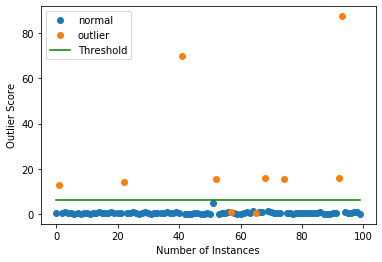

In [23]:
plot_outlier_scores(scores, target, labels, threshold)

## Use OHE instead of ordinal encoding for the categorical variables

Since we will apply one-hot encoding (OHE) on the categorical variables, we convert `cat_vars_ord` from the ordinal to OHE format. `alibi.utils.mapping` contains utility functions to do this. The keys in `cat_vars_ohe` now represent the first column index for each one-hot encoded categorical variable. This dictionary will later be used in the counterfactual explanation.

In [24]:
cat_vars_ohe = ord_to_ohe(X_fit, cat_vars_ord)[1]
print(cat_vars_ohe)

{0: 3, 3: 66, 69: 11}


Fit a one-hot encoder on the categorical data:

In [25]:
enc = OneHotEncoder(categories='auto')
enc.fit(X_fit[:, :n_categories])

OneHotEncoder(categorical_features=None, categories='auto', drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='error',
              n_values=None, sparse=True)

Transform `X_fit` to OHE:

In [26]:
X_ohe = enc.transform(X_fit[:, :n_categories])
X_fit = np.array(np.c_[X_ohe.todense(), X_fit[:, n_categories:]].astype(np.float32, copy=False))
print(X_fit.shape)

(494021, 98)


Transform outlier batch to OHE:

In [27]:
X_ohe = enc.transform(X_ord)
X = np.array(np.c_[X_ohe.todense(), X_num].astype(np.float32, copy=False))
print(X.shape)

(100, 98)


## Initialize and fit outlier detector

In [28]:
mh = Mahalanobis(threshold,
                 n_components=n_components, 
                 std_clip=std_clip, 
                 start_clip=start_clip,
                 cat_vars=cat_vars_ohe,
                 ohe=True
                )

Apply fit method:

In [29]:
mh.fit(X_fit,
       d_type=d_type,
       disc_perc=disc_perc,
       standardize_cat_vars=standardize_cat_vars
      )

## Run outlier detector and display results

In [30]:
preds = mh.predict(X)
scores = mh.score(mh.cat2num(X))

Confusion matrix:

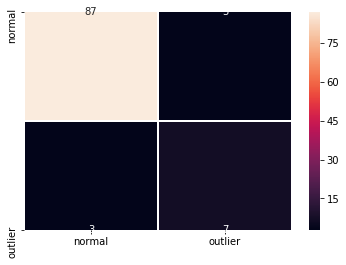

In [31]:
cm = confusion_matrix(target, preds)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
sns.heatmap(df_cm, annot=True, cbar=True, linewidths=.5)
plt.show()

Plot scores vs. the outlier threshold:

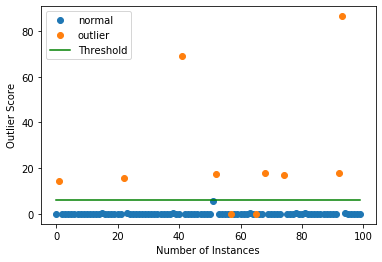

In [32]:
plot_outlier_scores(scores, target, labels, threshold)